<a href="https://colab.research.google.com/github/Srujanavalavala/fmml-lab-1/blob/main/FMML_Module_9_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

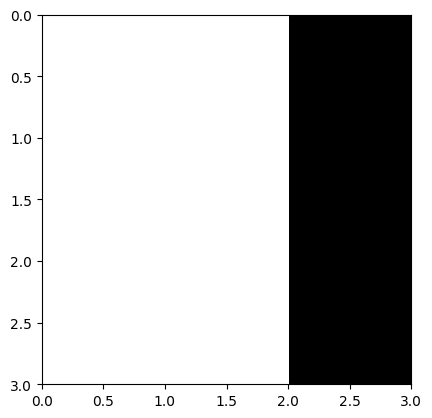

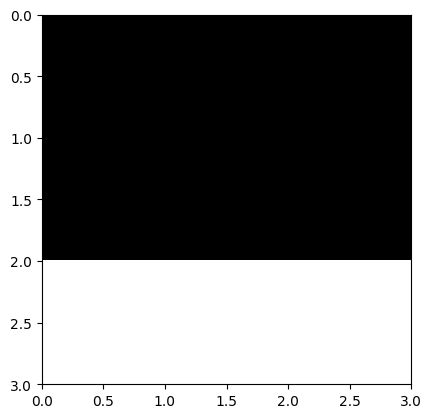

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [9]:
def apply_conv(image, filter, padding=0, stride=1):
    # Print input parameters
    print("Image shape:", image.shape)
    print("Filter shape:", filter.shape)
    print("Padding:", padding)
    print("Stride:", stride)

    # Get image dimensions
    img_h, img_w = image.shape

    # Get filter dimensions
    filter_h, filter_w = filter.shape

    # Compute output dimensions after applying padding and stride
    out_h = int((img_h - filter_h + 2 * padding) / stride) + 1
    out_w = int((img_w - filter_w + 2 * padding) / stride) + 1

    # Print output dimensions
    print("Output shape:", (out_h, out_w))

    # Initialize the output image with zeros
    output = np.zeros((out_h, out_w), dtype=float)

    # Pad the image if padding is specified
    if padding > 0:
        padded_image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    else:
        padded_image = image

    # Apply convolution
    for y in range(0, out_h):
        for x in range(0, out_w):
            # Extract the region to apply the filter on
            region = padded_image[y * stride: y * stride + filter_h, x * stride: x * stride + filter_w]

            # Element-wise multiplication with the filter and then sum to get the convolution output
            output[y, x] = np.sum(region * filter)

    return output

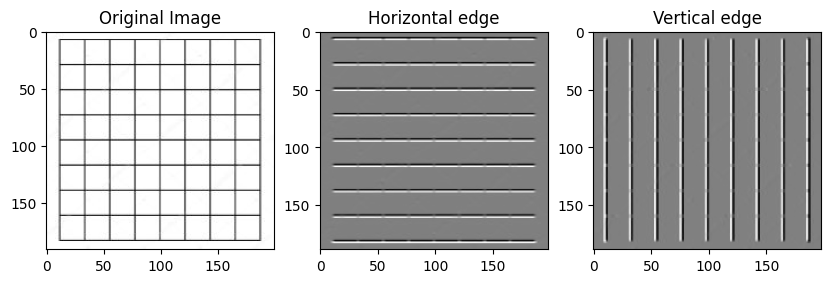

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,3,2)
ax.set_title('Horizontal edge')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(out2, cmap='gray')
ax.set_title('Vertical edge')
plt.show()


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [10]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 52419813.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [13]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [14]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [15]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [18]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [19]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5, Loss: 0.0130, Accuracy: 38.6420
Epoch 2/5, Loss: 0.0092, Accuracy: 58.4260
Epoch 3/5, Loss: 0.0078, Accuracy: 65.1020
Epoch 4/5, Loss: 0.0066, Accuracy: 70.3740
Epoch 5/5, Loss: 0.0056, Accuracy: 74.6020


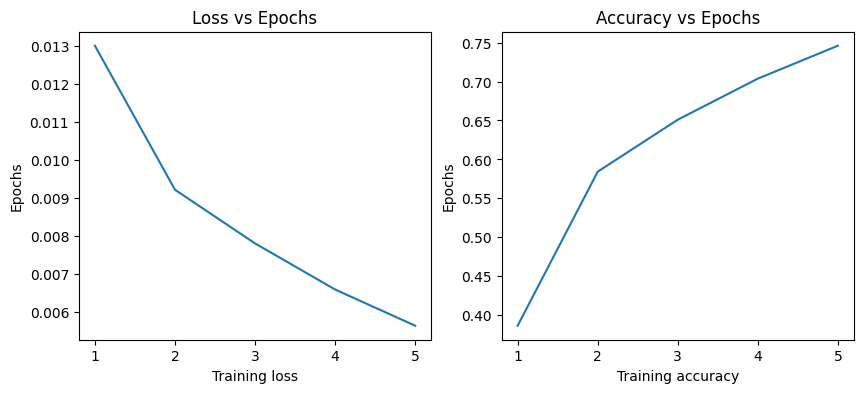

In [20]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [21]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 67 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


**ANSWERS**

ANS 1:

Convolutional Neural Networks (CNNs) are generally preferred over Artificial Neural Networks (ANNs) for image classification due to their unique architecture and design that makes them more suitable for handling visual data. Here are some reasons why CNNs are favored for image classification:

1. **Spatial Hierarchies**:
   - CNNs have a unique ability to detect spatial hierarchies in images. Convolutional layers apply filters that can identify simple features like edges or textures in early layers, and more complex patterns in deeper layers.

2. **Parameter Reduction**:
   - CNNs use shared weights (filters), which drastically reduces the number of parameters compared to ANNs. This reduces memory requirements and makes training faster and more efficient.

3. **Translation Invariance**:
   - CNNs are inherently more robust to spatial variations, as convolution operations maintain spatial relationships while applying filters. This makes them less sensitive to changes in image orientation or position.

4. **Local Connectivity**:
   - CNNs use a localized approach to analyze data. Filters operate on small local regions, allowing them to extract relevant features from specific parts of the image without processing the entire input at once.

5. **Pooling Layers**:
   - CNNs often include pooling layers, which reduce the spatial dimensions of feature maps while preserving key information. This helps reduce the complexity of the network and adds robustness to small shifts or distortions in images.

6. **Layer-by-Layer Feature Extraction**:
   - CNNs typically consist of multiple convolutional layers that extract increasingly complex features. This approach mimics the human visual system and allows CNNs to learn hierarchical features that represent images more effectively.

7. **Improved Generalization**:
   - Due to the reduced number of parameters, local connectivity, and translation invariance, CNNs tend to generalize better than ANNs, resulting in more robust performance across different image data sets.

In summary, CNNs are preferred over ANNs for image classification because they are specifically designed to handle spatial data effectively, offer parameter efficiency, and can capture complex hierarchical patterns in images with better generalization and robustness.


ANS 2:

Tuning hyperparameters can significantly impact the performance of a Convolutional Neural Network (CNN). Hyperparameters include the number of epochs, optimizer choice, learning rate (LR), batch size, and other training parameters. To improve test accuracy, you can experiment with different combinations of these hyperparameters.

Since I can't directly execute training or measure test accuracy, I'll provide a list of key hyperparameters to consider for improving CNN performance. Here's what you can do to achieve better results with your CNN model:

1. **Number of Epochs**:
   - Increasing the number of epochs can improve model performance, but watch out for overfitting. Early stopping techniques can help find an optimal point to halt training when validation loss stops improving.

2. **Learning Rate (LR)**:
   - A well-chosen learning rate is critical. Too high, and the model might not converge; too low, and it might take too long to train. Consider using learning rate schedules or learning rate annealing for gradual changes during training.

3. **Optimizer**:
   - Experiment with different optimizers like Adam, RMSprop, or SGD (Stochastic Gradient Descent). Each optimizer has its characteristics, with Adam generally being a good starting point for deep learning tasks.

4. **Batch Size**:
   - A larger batch size can speed up training but might require more memory. Smaller batch sizes can provide a regularization effect. Choose a balance that works with your hardware constraints.

5. **Data Augmentation**:
   - Use data augmentation techniques to artificially expand your training dataset, helping prevent overfitting. Techniques include rotations, flips, zooms, and shifts.

6. **Dropout and Regularization**:
   - Implement dropout layers to reduce overfitting by randomly deactivating a percentage of neurons during training. L2 regularization (weight decay) is another approach to reduce overfitting.

7. **Advanced Architectures**:
   - Experiment with deeper networks, residual connections (ResNets), or other advanced architectures to improve learning capacity.

8. **Cross-Validation and Grid Search**:
   - To find the best combination of hyperparameters, consider using cross-validation and grid search techniques to systematically explore different values.

By tuning these hyperparameters and using techniques like data augmentation and dropout, you should be able to improve the performance of your CNN. For reporting improved test accuracy, the actual accuracy improvement would require running the code, conducting experiments, and measuring results based on the tuning process.

ANS 3:

Reducing the number of convolution layers to only one has significant effects on a Convolutional Neural Network (CNN). Here's what happens:

1. **Reduced Learning Capacity**:
   - With a single convolution layer, the network's ability to learn complex features and hierarchies is limited. Multiple convolution layers allow for learning at different levels of abstraction, from basic edges and shapes to more complex patterns. Reducing to one layer restricts this ability.

2. **Limited Feature Extraction**:
   - Convolutional layers extract features from input data. A single convolution layer can only capture basic features, typically low-level ones like edges and textures. Deeper networks with multiple convolution layers are more effective at identifying increasingly complex features.

3. **Decreased Model Complexity**:
   - Reducing to one convolution layer lowers the model's complexity, which can be beneficial for simpler tasks or low-resource environments. However, it often comes at the cost of reduced accuracy and generalization capability.

4. **Less Robustness**:
   - Deep CNNs with multiple convolution layers are generally more robust to variations in input data, such as changes in scale, rotation, or noise. A single convolution layer may lack the depth needed to capture these variations, leading to reduced robustness.

5. **Potential Overfitting**:
   - Although deeper networks are more prone to overfitting, reducing to one convolution layer doesn't necessarily prevent overfitting. The reduced learning capacity might lead to a model that fits the training data well but fails to generalize.

6. **Simpler Architectures and Faster Training**:
   - A single convolution layer results in simpler architectures and fewer parameters, leading to faster training and lower resource requirements. This can be advantageous for lightweight applications or scenarios where computational resources are limited.

In summary, reducing the number of convolution layers to only one simplifies the network and reduces learning capacity, potentially leading to decreased accuracy and robustness. It can be useful for simpler tasks or low-resource settings but generally isn't suitable for complex image classification problems where multiple convolution layers are essential to capture intricate patterns and hierarchies.

ANS 4:

The choice of whether to use the Softmax activation function in the last layer of a Convolutional Neural Network (CNN) depends on the specific task the network is designed to perform. Generally, Softmax is used when the network is solving a multi-class classification problem. However, there are several reasons why one might choose not to use Softmax in the last layer of a CNN:

1. **Different Problem Type**:
   - If the task is not a multi-class classification problem, Softmax might not be appropriate. For example, in regression tasks, object detection, or binary classification, other activation functions are more suitable. In regression, linear activation might be used; in binary classification, Sigmoid is common.

2. **Intermediate Layer Activation**:
   - If the network has a sequence of outputs before reaching the final result, Softmax may not be required in earlier stages. For example, in object detection networks like YOLO, Softmax isn't typically used in intermediate layers.

3. **Special Architectures**:
   - Some advanced architectures require a different approach. For instance, in CNNs used for image segmentation, the final layer might use a linear activation or another custom setup rather than Softmax.

4. **Post-Processing Outside the Network**:
   - In some cases, the final layer might output raw scores or logits, with Softmax applied later in the processing pipeline. This approach can give more flexibility for downstream operations or ensemble methods.

5. **Gradient Instability**:
   - Although Softmax is common in classification tasks, it can sometimes lead to gradient instability in complex networks or when combined with certain loss functions. Avoiding Softmax in these cases can help stabilize the network's learning.

6. **Efficiency and Model Complexity**:
   - In some architectures, not using Softmax can reduce computational overhead and model complexity, particularly in lightweight or embedded applications where efficiency is crucial.

If you don't use Softmax in the last layer of a CNN, it's often because the network is performing a task other than multi-class classification, or there's a specific architecture-related reason. If you do need Softmax's properties, such as obtaining probabilities that sum to one, it might be used explicitly after obtaining the raw outputs.